In [1]:
# Trick to import local code:
import sys
sys.path = ['/home/mp/michelj/src/sensorsio/src'] + sys.path

In [2]:
from sensorsio import sentinel2
import rasterio as rio
from matplotlib import pyplot as plt
import glob
import xml.etree.ElementTree as ET
import numpy as np
from scipy import interpolate, ndimage
import torch

/work/scratch/michelj/virtualenv/data-science/lib/python3.8/site-packages/geopandas/_compat.py:106: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.9.0-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(


In [3]:
from importlib import reload
reload(sentinel2)

<module 'sensorsio.sentinel2' from '/home/mp/michelj/src/sensorsio/src/sensorsio/sentinel2.py'>

In [4]:
#product_dir='/datalake/S2-L2A-THEIA/31TDH/2019/05/31/SENTINEL2B_20190531-105916-927_L2A_T31TDH_C_V2-2/'
#product_dir='/datalake/S2-L2A-THEIA/31TCL/2020/06/24/SENTINEL2B_20200624-105832-534_L2A_T31TCL_C_V2-2'
#product_dir='/datalake/S2-L2A-THEIA/31TFJ/2020/07/06/SENTINEL2A_20200706-104854-661_L2A_T31TFJ_C_V2-2'
#product_dir='/datalake/S2-L2A-THEIA/31TFJ/2020/03/08/SENTINEL2A_20200308-104846-201_L2A_T31TFJ_C_V2-2'
product_dir='/datalake/S2-L2A-THEIA/31TGH/2020/06/28/SENTINEL2B_20200628-103907-836_L2A_T31TGH_C_V2-2'

In [5]:
dataset = sentinel2.Sentinel2(product_dir)

# Masks

In [6]:
detectors_masks = dataset.build_detectors_masks_path()

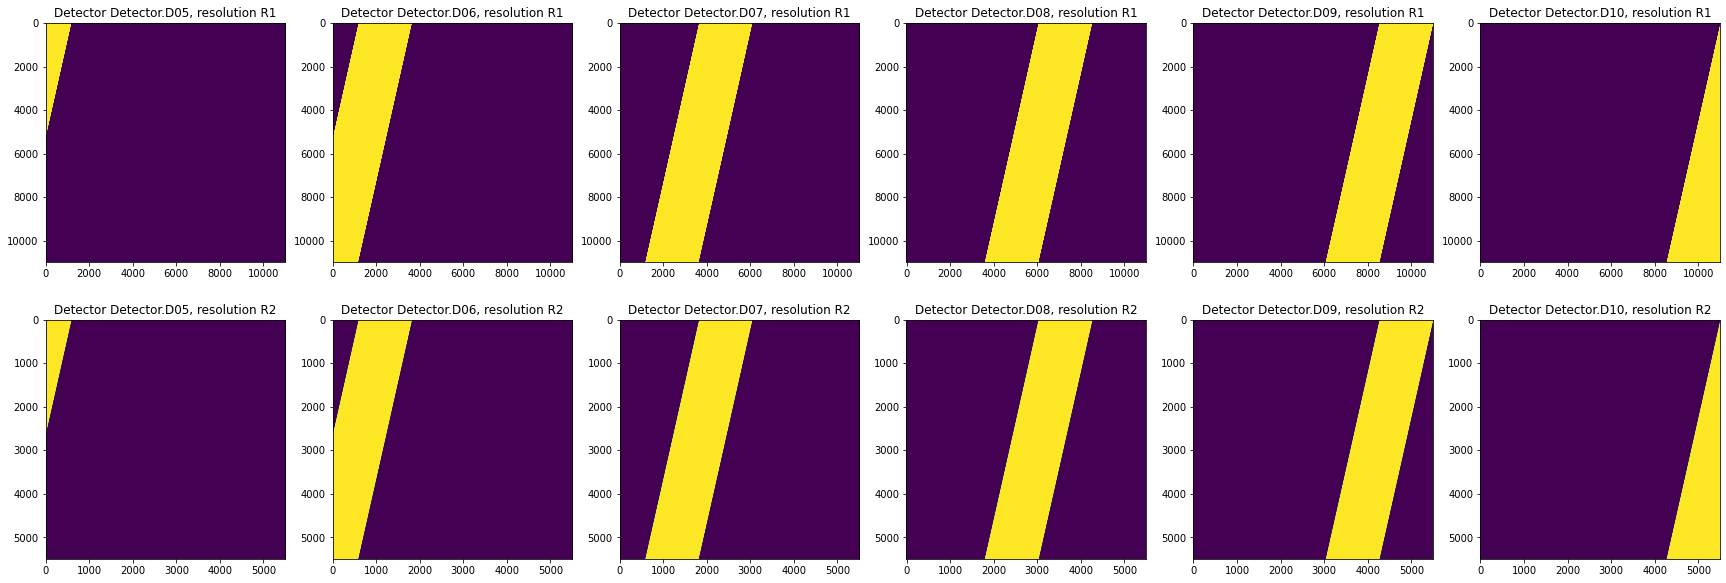

In [7]:
plot_size=5
fig, axes = plt.subplots(ncols=len(detectors_masks), nrows=2, figsize=(len(detectors_masks)*plot_size,2*plot_size))
for i,(key, val) in enumerate(detectors_masks.items()):
    with rio.open(val.r1) as ds:
        axes[0,i].imshow(ds.read(1))
        axes[0,i].set_title(f'Detector {key}, resolution R1')
    with rio.open(val.r2) as ds:
        axes[1,i].imshow(ds.read(1))
        axes[1,i].set_title(f'Detector {key}, resolution R2')
        

In [14]:
previous_mask=None
previous_det = None
for i,(key, val) in enumerate(detectors_masks.items()):
    with rio.open(val.r1) as ds:
        mask=ds.read(1)
        if previous_mask is not None:
            overlap = np.logical_and(mask>0, previous_mask>0).sum()
            print(f"Overlap between masks of detectors {previous_det} and {key}: {overlap} pixels")
        previous_mask=mask
        previous_det = key

Overlap between masks of detectors Detector.D05 and Detector.D06: 4993 pixels
Overlap between masks of detectors Detector.D06 and Detector.D07: 6131 pixels
Overlap between masks of detectors Detector.D07 and Detector.D08: 9102 pixels
Overlap between masks of detectors Detector.D08 and Detector.D09: 37652 pixels
Overlap between masks of detectors Detector.D09 and Detector.D10: 26165 pixels


# Raw angles 

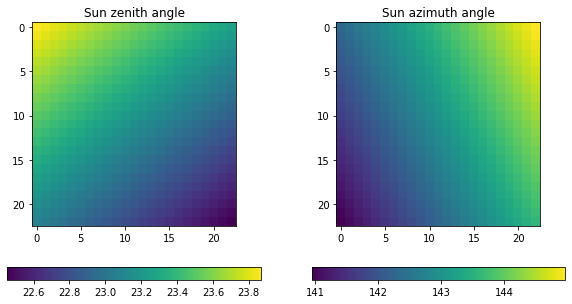

In [8]:
plot_size=5
fig, axes = plt.subplots(ncols=2, figsize=(2*plot_size,plot_size))
p = axes[0].imshow(dataset.sun_angles.zenith)
axes[0].set_title('Sun zenith angle')
fig.colorbar(p, ax=axes[0], orientation='horizontal', fraction=.1)
p = axes[1].imshow(dataset.sun_angles.azimuth)
axes[1].set_title('Sun azimuth angle')
fig.colorbar(p, ax=axes[1], orientation='horizontal', fraction=.1)

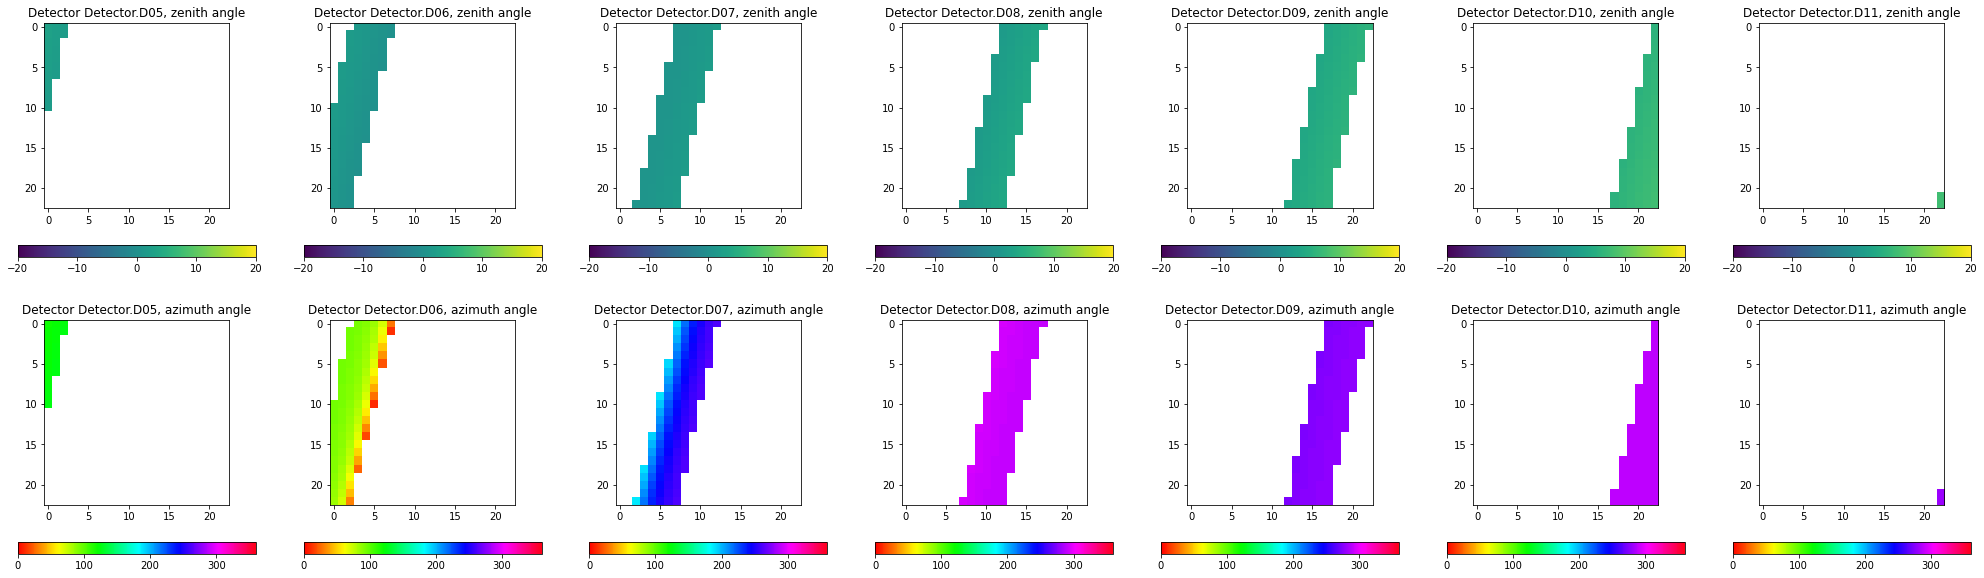

In [9]:
band = sentinel2.Sentinel2.B2
plot_size=5
fig, axes = plt.subplots(ncols=len(dataset.incidence_angles[band]), nrows=2, figsize=(len(dataset.incidence_angles[band])*plot_size,2*plot_size))
for i,(key, val) in enumerate(dataset.incidence_angles[band].items()):
    p = axes[0,i].imshow(val.zenith, vmin=-20, vmax=20)
    axes[0,i].set_title(f'Detector {key}, zenith angle')
    fig.colorbar(p, ax=axes[0,i], orientation='horizontal', fraction=.1)
    p = axes[1,i].imshow(val.azimuth, vmin=0, vmax=360, cmap='hsv')
    axes[1,i].set_title(f'Detector {key}, azimuth angle')
    fig.colorbar(p, ax=axes[1,i], orientation='horizontal', fraction=.1)

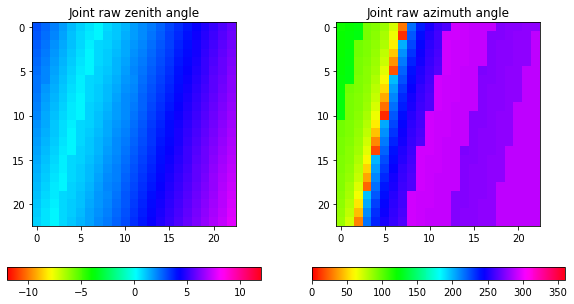

In [10]:
joint_raw_zenith = np.full((23,23),np.nan)
joint_raw_azimuth = np.full((23,23),np.nan)

for i,(key, val) in enumerate(dataset.incidence_angles[sentinel2.Sentinel2.B2].items()):
    joint_raw_zenith[np.isnan(joint_raw_zenith)]=val.zenith[np.isnan(joint_raw_zenith)]
    joint_raw_azimuth[np.isnan(joint_raw_azimuth)]=val.azimuth[np.isnan(joint_raw_azimuth)]

plot_size=5
fig, axes = plt.subplots(ncols=2, figsize=(2*plot_size,plot_size))
p = axes[0].imshow(joint_raw_zenith, vmin=-12, vmax=12, cmap='hsv')
axes[0].set_title('Joint raw zenith angle')
fig.colorbar(p, ax=axes[0], orientation='horizontal', fraction=.1)
p = axes[1].imshow(joint_raw_azimuth, vmin=0, vmax=360, cmap='hsv')
axes[1].set_title('Joint raw azimuth angle')
fig.colorbar(p, ax=axes[1], orientation='horizontal', fraction=.1)

# Full resolution angles

In [11]:
sun_zen, sun_az = dataset.read_solar_angles_as_numpy()

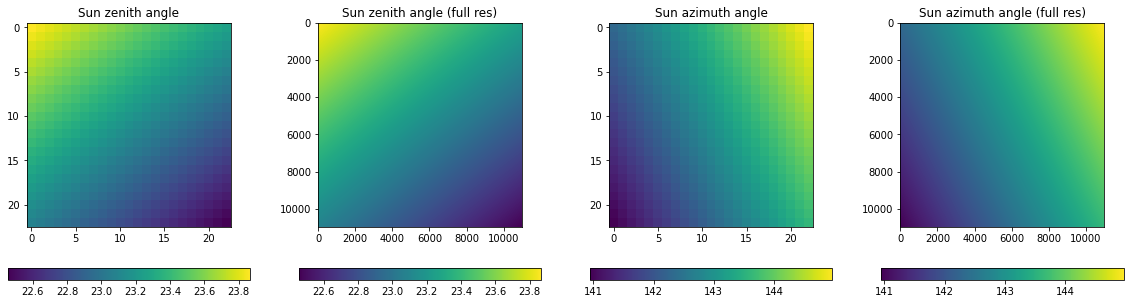

In [12]:
plot_size=5
fig, axes = plt.subplots(ncols=4, figsize=(4*plot_size,plot_size))
p = axes[0].imshow(dataset.sun_angles.zenith)
axes[0].set_title('Sun zenith angle')
fig.colorbar(p, ax=axes[0], orientation='horizontal', fraction=.1)
p = axes[1].imshow(sun_zen)
axes[1].set_title('Sun zenith angle (full res)')
fig.colorbar(p, ax=axes[1], orientation='horizontal', fraction=.1)
p = axes[2].imshow(dataset.sun_angles.azimuth)
axes[2].set_title('Sun azimuth angle')
fig.colorbar(p, ax=axes[2], orientation='horizontal', fraction=.1)
p = axes[3].imshow(sun_az)
axes[3].set_title('Sun azimuth angle (full res)')
fig.colorbar(p, ax=axes[3], orientation='horizontal', fraction=.1)


In [13]:
even_zen, odd_zen, even_az, odd_az = dataset.read_incidence_angles_as_numpy()

In [15]:
joint_zen = np.array(even_zen)
joint_zen[np.isnan(even_zen)]=odd_zen[np.isnan(even_zen)]
joint_az = np.array(even_az)
joint_az[np.isnan(even_az)]=odd_az[np.isnan(even_az)]

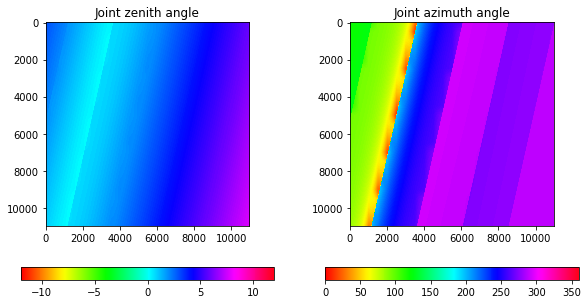

In [16]:
plot_size=5
fig, axes = plt.subplots(ncols=2, figsize=(2*plot_size,plot_size))
p=axes[0].imshow(joint_zen, vmin=-12, vmax=12, cmap='hsv')
axes[0].set_title('Joint zenith angle')
fig.colorbar(p, ax=axes[0], orientation='horizontal', fraction=.1)
p=axes[1].imshow(joint_az, vmin=0, vmax=360, cmap='hsv')
axes[1].set_title('Joint azimuth angle')
fig.colorbar(p, ax=axes[1], orientation='horizontal', fraction=.1)

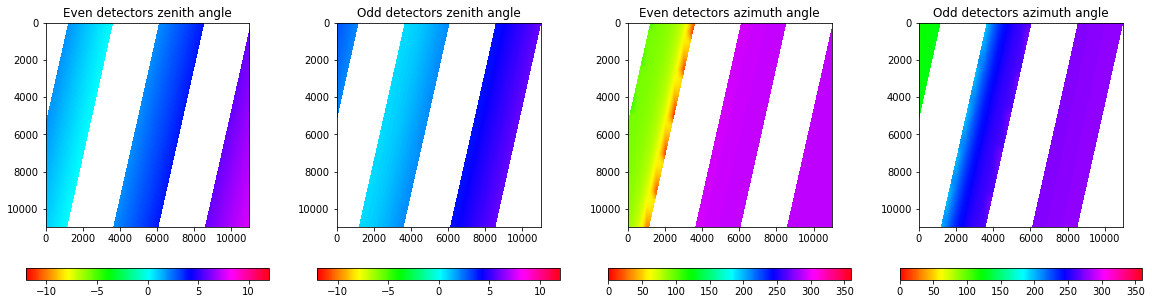

In [19]:
plot_size=5
fig, axes = plt.subplots(ncols=4, figsize=(4*plot_size,plot_size))
p = axes[0].imshow(even_zen, vmin=-12, vmax=12, cmap='hsv')
axes[0].set_title('Even detectors zenith angle')
fig.colorbar(p, ax=axes[0], orientation='horizontal', fraction=.1)
p = axes[1].imshow(odd_zen, vmin=-12, vmax=12, cmap='hsv')
axes[1].set_title('Odd detectors zenith angle')
fig.colorbar(p, ax=axes[1], orientation='horizontal', fraction=.1)
p = axes[2].imshow(even_az, vmin=0, vmax=360, cmap='hsv')
axes[2].set_title('Even detectors azimuth angle')
fig.colorbar(p, ax=axes[2], orientation='horizontal', fraction=.1)
p = axes[3].imshow(odd_az, vmin=0, vmax=360, cmap='hsv')
axes[3].set_title('Odd detectors azimuth angle')
fig.colorbar(p, ax=axes[3], orientation='horizontal', fraction=.1)


# Analysis

In [20]:
red_band = dataset.read_as_numpy([sentinel2.Sentinel2.B4])
line=10500
s = 8600
e = 8700

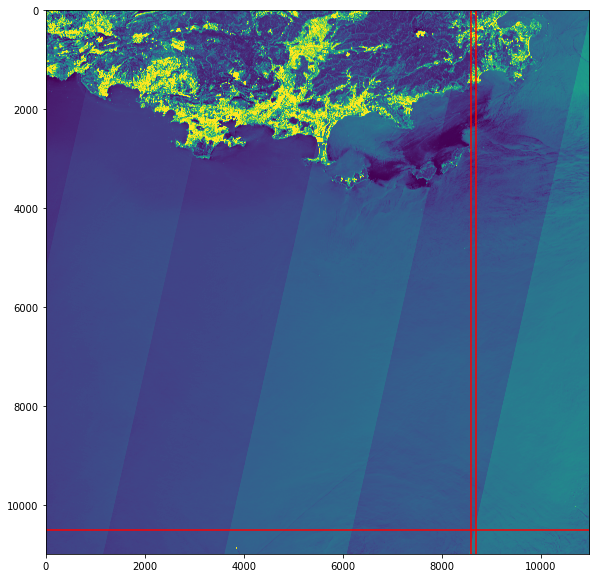

In [27]:
fig, axes = plt.subplots(figsize=(10,10))
axes.imshow(red_band[0][0,:,:], vmin=0., vmax=0.15)
axes.axhline(line, color='red')
axes.axvline(s, color='red')
axes.axvline(e, color='red')

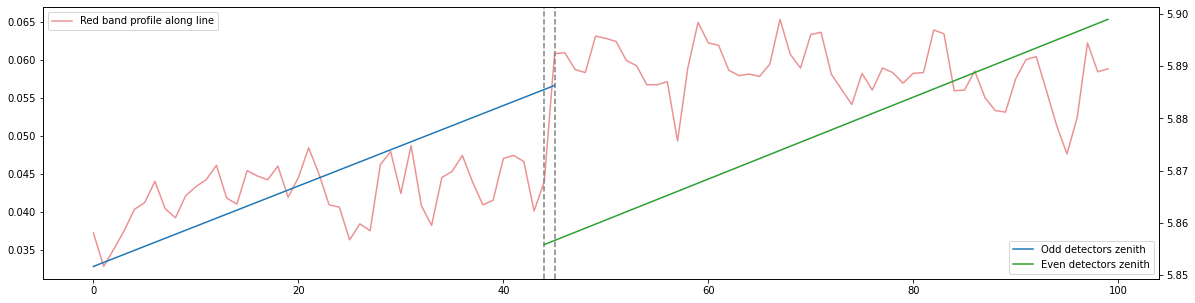

In [28]:
fig, axes = plt.subplots(figsize=(20,5))
axes.plot(red_band[0][0,line,s:e], color='tab:red', alpha=0.5,label='Red band profile along line')
axes.legend(loc='upper left')
axes.axvline(45,color='gray',linestyle='--')
axes.axvline(44,color='gray',linestyle='--')
ax2 = axes.twinx()
ax2.plot(odd_zen[line,s:e], color='tab:blue',label='Odd detectors zenith')
ax2.plot(even_zen[line,s:e], color='tab:green', label='Even detectors zenith')
ax2.legend(loc='lower right')